In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import torch
from sklearn.model_selection import train_test_split
from torch import nn

/opt/miniconda3/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
dataset = pd.read_csv("static_two_moons_combined.csv")
dataset

,x0,x1,x2,y,env_id,time,source
0,-0.164221,1.194907,-0.314877,0,0,0,env_000_train
1,-0.368972,-0.847034,0.318045,1,0,0,env_000_train
2,-0.598016,-0.550728,0.403196,1,0,0,env_000_train
3,-1.355549,1.267512,-0.317173,0,0,0,env_000_train
4,1.923942,-0.803257,0.273563,1,0,0,env_000_train
...,...,...,...,...,...,...,...
11995,-0.694545,-0.613716,-2.789839,1,5,5,env_005_test
11996,-1.978567,-0.582871,2.981433,0,5,5,env_005_test
11997,1.404878,-0.594109,-3.019377,1,5,5,env_005_test
11998,0.265274,0.500177,3.162122,0,5,5,env_005_test


In [3]:
x_coordinate = dataset["x0"]
y_coordinate = dataset["x1"]
classes      = dataset["y"]

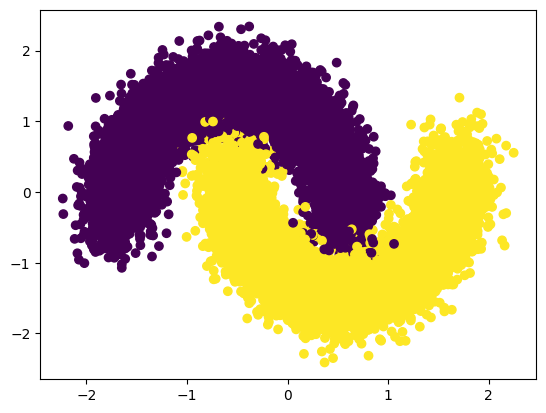

In [4]:
plt.scatter(x_coordinate, y_coordinate, c=classes)

In [5]:
def create_X(x, y): 
    X = [list(pair) for pair in zip(x, y)]
    return X

In [6]:
# create inputs to the neural network
X = np.array(create_X(x_coordinate, y_coordinate))
classes = np.array(classes)
X[:5]

array([[-0.16422112,  1.19490671],
       [-0.36897239, -0.84703422],
       [-0.59801584, -0.55072802],
       [-1.3555491 ,  1.26751184],
       [ 1.92394173, -0.80325705]])

In [7]:
X.shape, classes.shape

((12000, 2), (12000,))

In [8]:
# turn np array into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(classes).type(torch.float)
X[:5]

tensor([[-0.1642,  1.1949],
        [-0.3690, -0.8470],
        [-0.5980, -0.5507],
        [-1.3555,  1.2675],
        [ 1.9239, -0.8033]])

In [9]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # make the random split reproducible
len(X_train), len(X_test), y_test[:5]

(9600, 2400, tensor([0., 0., 0., 1., 1.]))

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
class Moon_nn(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10) # because input is the x, y coordinate. 
        self.layer2 = nn.Linear(in_features=10, out_features=1) # because output is a prediction, input is the output from last layer

    def forward(self, x): 
        x = self.layer1(x)
        x = self.layer2(x)
        return x

moon_model = Moon_nn().to(device)
moon_model

Moon_nn(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=1, bias=True)
)

In [12]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [13]:
# optimizer
lr = 1e-4; 
weight_decay = 1e-2
optimizer = torch.optim.AdamW(moon_model.parameters(), lr=lr, weight_decay=weight_decay) 
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

In [14]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

In [15]:
epochs = 2000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [16]:
training_loss = []
training_accuracy = []
testing_loss = []
testing_accuracy = []
epoch_list = []
for epoch in range(epochs):
    moon_model.train()

    y_logits = moon_model(X_train).squeeze() # 1D
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits to probability, round to 0/1
    
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    moon_model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = moon_model(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 50 == 0:
        epoch_list.append(epoch)
        testing_loss.append(test_loss)
        testing_accuracy.append(test_acc)
        training_loss.append(loss)
        training_accuracy.append(acc)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70784, Accuracy: 50.34% | Test loss: 0.71510, Test acc: 48.62%
Epoch: 50 | Loss: 0.69562, Accuracy: 50.34% | Test loss: 0.70234, Test acc: 48.62%
Epoch: 100 | Loss: 0.68393, Accuracy: 50.34% | Test loss: 0.69014, Test acc: 48.62%
Epoch: 150 | Loss: 0.67274, Accuracy: 50.34% | Test loss: 0.67846, Test acc: 48.62%
Epoch: 200 | Loss: 0.66201, Accuracy: 50.36% | Test loss: 0.66726, Test acc: 48.75%
Epoch: 250 | Loss: 0.65168, Accuracy: 51.08% | Test loss: 0.65648, Test acc: 49.54%
Epoch: 300 | Loss: 0.64171, Accuracy: 56.06% | Test loss: 0.64609, Test acc: 54.25%
Epoch: 350 | Loss: 0.63205, Accuracy: 64.32% | Test loss: 0.63603, Test acc: 63.58%
Epoch: 400 | Loss: 0.62267, Accuracy: 71.40% | Test loss: 0.62625, Test acc: 70.50%
Epoch: 450 | Loss: 0.61351, Accuracy: 75.77% | Test loss: 0.61672, Test acc: 74.92%
Epoch: 500 | Loss: 0.60454, Accuracy: 78.65% | Test loss: 0.60739, Test acc: 77.92%
Epoch: 550 | Loss: 0.59573, Accuracy: 80.16% | Test loss: 0.59824, Test acc: 79

In [17]:
type(training_loss[0]), float(training_loss[0])
training_loss = [float(loss) for loss in training_loss]
testing_loss = [float(loss) for loss in testing_loss]
training_accuracy = [float(loss) for loss in training_accuracy]
testing_accuracy = [float(loss) for loss in testing_accuracy]


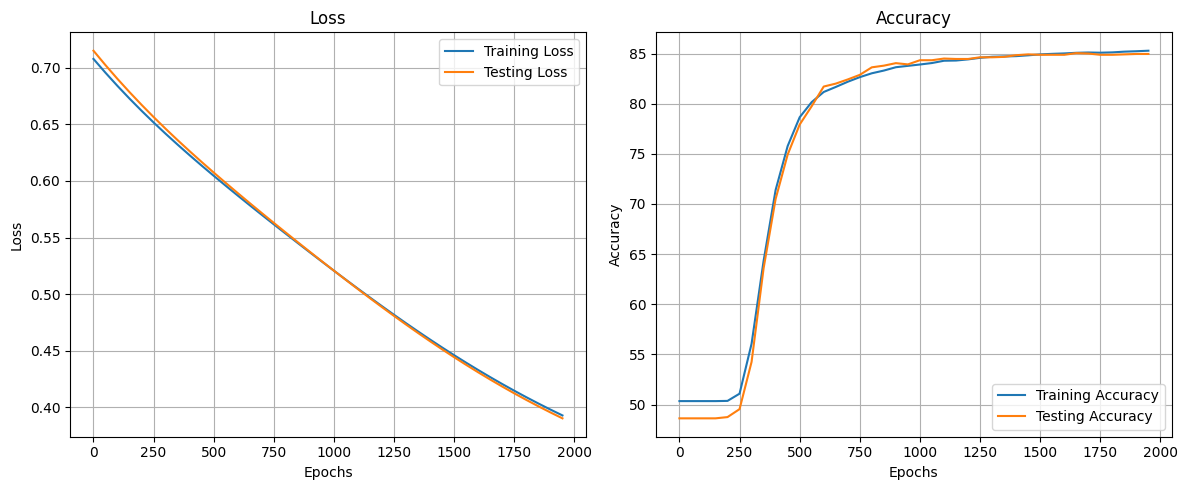

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the loss metrics on the first subplot (ax1)
ax1.plot(epoch_list, training_loss, label='Training Loss')
ax1.plot(epoch_list, testing_loss, label='Testing Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epoch_list, training_accuracy, label='Training Accuracy')
ax2.plot(epoch_list, testing_accuracy, label='Testing Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [19]:
len(epoch_list), len(training_loss), len(training_accuracy), len(training_loss), len(testing_accuracy), len(testing_loss)

(40, 40, 40, 40, 40, 40)